<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(MolecularGeometry)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
!pip install qiskit-algorithms==0.3.1
!pip install qiskit-nature[pyscf]==0.7.2
!pip install pyscf==2.6.0
!pip install py3Dmol

In [2]:
import warnings
warnings.filterwarnings('ignore')

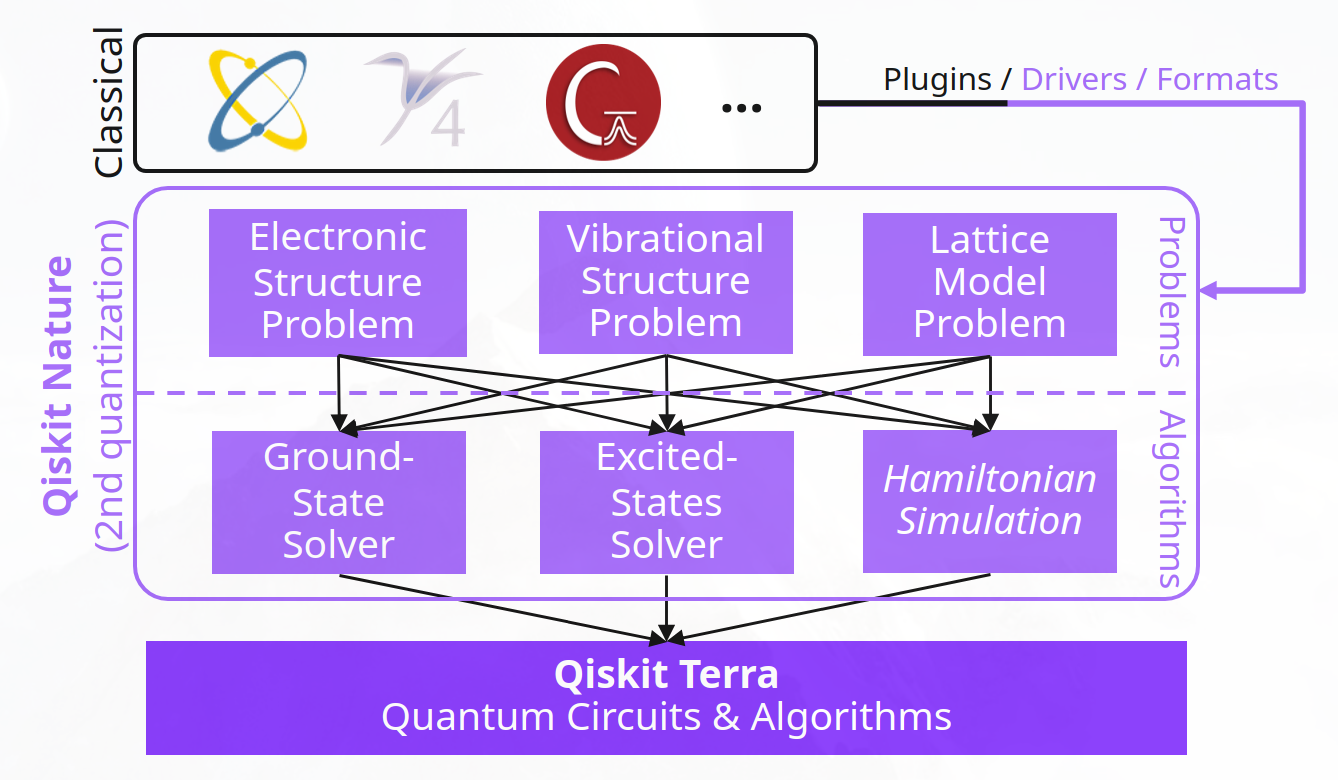

# **VQE (Variational Quantum Eigensolver) 구현<br>**
몇가지 분자들의 바닥 상태 에너지 계산 예제

In [ ]:
import numpy as np
import datetime
import time

#분자 구조(좌표)를 입력할 때 길이의 단위를 명확하게 지정하기 위한 열거형(Enum) 클래스, Ångström이야? Bohr이야? nm이야?”
from qiskit_nature.units import DistanceUnit

"""
→ 실제 분자의 전자 구조(오비탈, 에너지, 1체/2체 적분 등)를 고전적으로 정확히 계산해서 양자 컴퓨터가 쓸 수 있는 2차 양자화 해밀토니안으로 바꿔주는 핵심 브릿지 역할, 쉽게 말해,
→ H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안으로 변환해 줌”

→ second quantization(제2 양자화)은 양자 다체계 문제를 효율적으로 모델링하기 위한 핵심 기법입니다. 이는 생성(creation)과 소멸(annihilation) 연산자를 사용해 해밀토니안을 표현하는 방식으로,
→ 각 Problem 클래스(ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem)는 second_q_ops() 메서드를 통해
→ econd-quantized operator(주로 FermionicOp 또는 BosonicOp 형태)를 생성합니다. 이 연산자는 이후 QubitMapper(Jordan-Wigner, Parity 등)를 통해 큐비트 연산자로 변환되어 양자 알고리즘(VQE 등)에서 사용
"""
from qiskit_nature.second_q.drivers import PySCFDriver, Psi4Driver, GaussianDriver, ElectronicStructureDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

#실행하기 전에 분자 해밀토니안을 작고 계산 가능한 크기로 줄여주는 전처리 도구
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer, BasisTransformer

#from qiskit_nature.second_q.mappers.QubitConverter import QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem, VibrationalStructureProblem, LatticeModelProblem
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, ExcitedStatesSolver, ExcitedStatesEigensolver, QEOM, QEOMResult, EvaluationRule, GroundStateSolver, GroundStateEigensolver

#Classical Optimizer
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA, NFT, P_BFGS, QNSPSA, P_BFGS, ADAM, adam_amsgrad, NELDER_MEAD, POWELL, TNC, CG, NFT, IMFIL, SNOBFIT, BOBYQA, GSLS, AQGD

#Aanstz
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal

#Hartree-Fock (HF) 방법은 양자 화학에서 다전자 원자나 분자의 전자 구조를 근사적으로 계산하는 기본적인 방법입니다. "Hartree-Fock solution"은
#이 방법으로 얻어진 최적화된 파동함수와 에너지를 의미하며, 정확한 슈뢰딩거 방정식 해가 아닌 최선의 단일 Slater determinant 근사
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

#from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator

from qiskit_algorithms import VQE

print("=" * 60)
print("VQE를 이용한 분자 에너지 계산")
print("=" * 60)

**물분자(H2O) 좌표계산법 예**

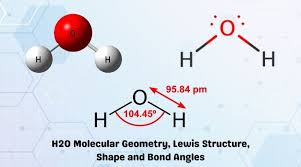

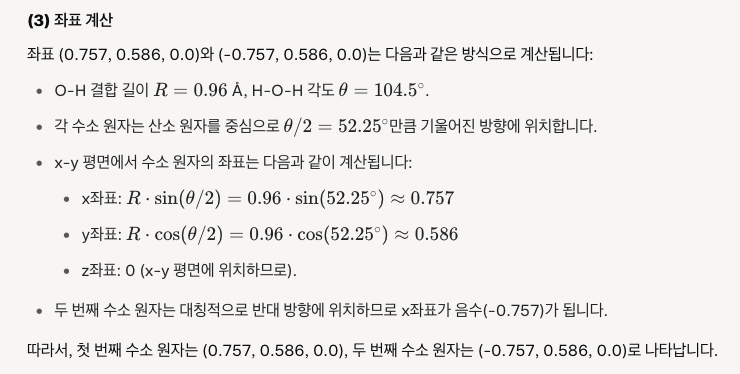

In [44]:
# 1. 분자 (구조)정의 (H2 분자)
print("-" * 60)
print("[1단계] 분자 구조 정의")
print("-" * 60)

# 0.1. 수소분자 정의
# 수소 분자 정의 (원자간 거리: 0.74 Angstrom)
h2 =  "H 0.0 0.0 0.0; \
       H 0.0 0.0 0.74"

# 0.2. 분자 중심이 원점에 오는 대칭 버전
h2_center = "H 0.0 0.0 -0.37; \
             H 0.0 0.0 0.37"

# 0.3. Bohr 단위로 주고 싶을 때 (많은 양자화학 프로그램 기본 단위)
h2_bohr = "H 0.0 0.0 0.0; \
           H 0.0 0.0 1.4"   # 1.4 a.u. ≈ 0.74 Å

# 1. 물분자 H₂O (이미 있으시지만 참고용으로 다시)
h2o = "O 0.000000 0.000000 0.000000; \
       H 0.757000 0.586000 0.000000; \
       H -0.757000 0.586000 0.000000"

# 2. 메탄 CH₄ (Td 대칭)
ch4 = "C 0.000000 0.000000 0.000000; \
       H 0.626800 0.626800 0.626800; \
       H 0.626800 -0.626800 -0.626800; \
       H -0.626800 0.626800 -0.626800; \
       H -0.626800 -0.626800 0.626800"

# 3. 에틸렌 C₂H₄ (D2h 대칭, 평면 구조)
c2h4 = "C 0.000000 0.000000 0.669500; \
        C 0.000000 0.000000 -0.669500; \
        H 0.928900 0.000000 1.237500; \
        H -0.928900 0.000000 1.237500; \
        H 0.928900 0.000000 -1.237500; \
        H -0.928900 0.000000 -1.237500"

# 4. 암모니아 NH₃ (C3v 대칭)
nh3 = "N 0.000000 0.000000 0.000000; \
       H 0.000000 0.951000 -0.267000; \
       H 0.823000 -0.475500 -0.267000; \
       H -0.823000 -0.475500 -0.267000"

# 5. 이산화탄소 CO₂ (D∞h 대칭, 선형)
co2 = "O -1.161000 0.000000 0.000000; \
       C  0.000000 0.000000 0.000000; \
       O  1.161000 0.000000 0.000000"

# 6. 보너스: 아세틸렌 C₂H₂ (D∞h 대칭, 선형)
c2h2 = "C 0.000000 0.000000 0.601000; \
        C 0.000000 0.000000 -0.601000; \
        H 0.000000 0.000000 1.662000; \
        H 0.000000 0.000000 -1.662000"


#이 부분을 바꾸어 주세요.
molecule = h2o

#H₂, H₂O, CH₄ 같은 분자를 주면, PySCF(하트리-포크 또는 DFT)로 분자 오비탈과 모든 적분을 계산해서 Qiskit이 VQE나 QAOA에 바로 넣을 수 있는 Pauli 문자열 해밀토니안로 변경
driver = PySCFDriver(
    atom=molecule,
    basis="sto3g",  # 기저 함수, 계산정확도와 비용을 결정, "sto3g"→매우빠름 교육용, "cc-pvdz"→실전표준,  "def2-tzvp"→고정밀, sto3g외 옵션은 메모리에러로 실습불가
    charge=0,       # 분자의 전체 전하, 중성 분자는 0, 양이온 +1, 음이온 -1,  0 (99%), +1 (LiH⁺, H₂⁺ 등), -1 (OH⁻ 등)
    spin=0,         # 스핀 다중도 2S+1 (0 = singlet 홀전자 1개 , 1 = doublet 짝전자, 2 = triplet …), 0 (H₂, H₂O, CH₄ 등 대부분),1 (OH 라디칼), 2 (O₂ triplet)
    unit=DistanceUnit.ANGSTROM  # 좌표 단위 (ANGSTROM 또는 BOHR)
)

###
##어떤 분자를, 어떤 단위로, 어떤 기저함수로, 몇 개의 전하와 스핀을 갖고 계산할까?
##를 완전히 결정하는 부분. 이 5개만 제대로 설정하면 나머지는 Qiskit이 알아서 다 해줌
###

------------------------------------------------------------
[1단계] 분자 구조 정의
------------------------------------------------------------


직접 Molecule 객체 만들 때<br>
from qiskit_nature.second_q.molecule import Molecule<br>

molecule = Molecule(<br>
    geometry=[<br>
        ["H", [0.0, 0.0, 0.0]],<br>
        ["H", [0.0, 0.0, 1.4]]       <br>
    ],<br>
    unit=DistanceUnit.BOHR          #여기선 Bohr 단위로 주고 싶다면, 여기서 명시<br>
)

In [45]:
import py3Dmol

def visualize_molecule(molecule_string, title="Molecule Visualization"):
    # Parse the molecule string into XYZ format
    atoms_data = molecule_string.strip().split(';')
    num_atoms = len(atoms_data)

    xyz_string = f"{num_atoms}\n{title}\n"
    atom_list = [] # Store atom details for individual labeling
    for atom_info in atoms_data:
        parts = atom_info.strip().split()
        if len(parts) == 4:  # Atom symbol and 3 coordinates
            atom_symbol = parts[0]
            x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
            xyz_string += f"{atom_symbol} {x:.6f} {y:.6f} {z:.6f}\n"
            atom_list.append({"atom": atom_symbol, "x": x, "y": y, "z": z}) # Store for individual labels
        else:
            print(f"Warning: Could not parse atom info: {atom_info}")
            continue
        ###if
    ###for

    # Create a 3Dmol view
    view = py3Dmol.view(width=800, height=600)
    view.addModel(xyz_string, 'xyz')
    view.setStyle({'stick':{'colorscheme':'byElement'}, 'sphere':{'scale':0.3, 'colorscheme':'byElement'}}) # Keep stick and sphere styles

    # Add labels for each atom explicitly
    for i, atom_data in enumerate(atom_list):
        view.addLabel(atom_data["atom"], {
            "position": {"x": atom_data["x"], "y": atom_data["y"], "z": atom_data["z"]},
            "font": 'sans-serif',
            "fontSize": 12,
            "fontColor": 'black',
            "showBackground": True,
            "backgroundColor": 'white' # Added background color for visibility
        })
    ###for

    view.zoomTo()
    view.show()
###def

In [46]:
# Visualize the currently selected molecule
visualize_molecule(molecule, "Selected Molecule")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [67]:
# 2. 전자 구조 문제 설정
print("-" * 60)
print("[2단계] 전자 구조 문제 설정")
print("-" * 60)

esproblem = driver.run()  # ← 여기서 모든 고전 계산이 일어남!
print(f"분자 궤도 개수: {problem.num_spatial_orbitals}")
print(f"전자 개수: {problem.num_particles}")

# Hamiltonian 얻기
hamiltonian = esproblem.hamiltonian.second_q_op()  # ← VQE에 바로 넣는 Pauli 해밀토니안

------------------------------------------------------------
[2단계] 전자 구조 문제 설정
------------------------------------------------------------
분자 궤도 개수: 7
전자 개수: (5, 5)


In [69]:
#number spin orbitals=4는 이 해밀토니안이 작용하는 스핀 오비탈(spin orbital)의 총 개수
#number terms=36은 second-quantized fermionic 해밀토니안에 포함된 독립적인 Pauli-like term(연산자 문자열)의 개수를 의미
print(hamiltonian)

Fermionic Operator
number spin orbitals=14, number terms=3150
  2.372248352384161 * ( +_0 +_0 -_0 -_0 )
+ -0.20831409786744706 * ( +_0 +_0 -_1 -_0 )
+ 0.09180183646543418 * ( +_0 +_0 -_3 -_0 )
+ -0.11905746595391378 * ( +_0 +_0 -_5 -_0 )
+ -0.20831409786744706 * ( +_0 +_1 -_0 -_0 )
+ 0.5022752592313259 * ( +_0 +_1 -_1 -_0 )
+ -0.06417601902559848 * ( +_0 +_1 -_3 -_0 )
+ 0.1542100643378556 * ( +_0 +_1 -_5 -_0 )
+ 0.40002207402677165 * ( +_0 +_2 -_2 -_0 )
+ 0.18120093908141946 * ( +_0 +_2 -_6 -_0 )
+ 0.09180183646543418 * ( +_0 +_3 -_0 -_0 )
+ -0.06417601902559848 * ( +_0 +_3 -_1 -_0 )
+ 0.5000018268716422 * ( +_0 +_3 -_3 -_0 )
+ 0.10960665820998351 * ( +_0 +_3 -_5 -_0 )
+ 0.5576680951820324 * ( +_0 +_4 -_4 -_0 )
+ -0.11905746595391378 * ( +_0 +_5 -_0 -_0 )
+ 0.1542100643378556 * ( +_0 +_5 -_1 -_0 )
+ 0.10960665820998351 * ( +_0 +_5 -_3 -_0 )
+ 0.4013473970427442 * ( +_0 +_5 -_5 -_0 )
+ 0.18120093908141946 * ( +_0 +_6 -_2 -_0 )
+ 0.4345426355843156 * ( +_0 +_6 -_6 -_0 )
+ 2.3722483523841

In [48]:
# 3. Qubit Mapping (Jordan-Wigner 변환)
print("-" * 60)
print("[3단계] Qubit Mapping")
print("-" * 60)

mapper = JordanWignerMapper()
#mapper = ParityMapper()
#mapper = BravyiKitaevMapper()
#mapper = TaperedQubitMapper(ParityMapper())
#mapper = DirectMapper()
#mapper = QubitMapper() //에러발생

qubit_op = mapper.map(hamiltonian)

print(f"필요한 큐비트 개수: {qubit_op.num_qubits}")
print(f"Pauli 항의 개수: {len(qubit_op)}")

------------------------------------------------------------
[3단계] Qubit Mapping
------------------------------------------------------------
필요한 큐비트 개수: 14
Pauli 항의 개수: 1086


In [49]:
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")
###for

-55.61460307 * IIIIIIIIIIIIII
+12.41351635 * IIIIIIIIIIIIIZ
+0.12505756 * IIIIIIIIIIIIXX
+0.12505756 * IIIIIIIIIIIIYY
+1.65659809 * IIIIIIIIIIIIZI
+0.23659510 * IIIIIIIIIIIIZZ
+1.21043460 * IIIIIIIIIIIZII
+0.19726224 * IIIIIIIIIIIZIZ
+0.00554345 * IIIIIIIIIIIZXX
+0.00554345 * IIIIIIIIIIIZYY
+0.12519188 * IIIIIIIIIIIZZI
+0.00325990 * IIIIIIIIIIXIXI
-0.00247787 * IIIIIIIIIIXIZX
-0.00171172 * IIIIIIIIIIXZIX
+0.11913021 * IIIIIIIIIIXZXI
+0.02646464 * IIIIIIIIIIXZXZ
-0.04274907 * IIIIIIIIIIXZZX
+0.00325990 * IIIIIIIIIIYIYI
-0.00247787 * IIIIIIIIIIYIZY
-0.00171172 * IIIIIIIIIIYZIY
+0.11913021 * IIIIIIIIIIYZYI
+0.02646464 * IIIIIIIIIIYZYZ
-0.04274907 * IIIIIIIIIIYZZY
+1.31584944 * IIIIIIIIIIZIII
+0.24305536 * IIIIIIIIIIZIIZ
+0.00812501 * IIIIIIIIIIZIXX
+0.00812501 * IIIIIIIIIIZIYY
+0.13791764 * IIIIIIIIIIZIZI
+0.13784238 * IIIIIIIIIIZZII
+1.37093709 * IIIIIIIIIZIIII
+0.27232284 * IIIIIIIIIZIIIZ
+0.01103841 * IIIIIIIIIZIIXX
+0.01103841 * IIIIIIIIIZIIYY
+0.15073619 * IIIIIIIIIZIIZI
+0.15003792 

결론: 위에서 본 숫자 7, (5,5), 14 qubit, 1086 Pauli는 H₂O를 sto-3g로 계산하고 아무런 active space 축소도 하지 않은, 완전한 full-space 전자 해밀토니안이라는 뜻. 교과서적인 정확한 값.

In [50]:
#print("-" * 60)
#print("[3.5단계] Active Space Reduction (선택 사항)")
#print("-" * 60)

# ActiveSpaceTransformer를 사용하여 활성 공간을 정의하고 Hamiltonian의 크기를 줄입니다.
# num_electrons: 활성 공간에 포함될 전자의 총 개수 (튜플 형태로 alpha, beta 전자 수 지정 가능)
# num_spatial_orbitals: 활성 공간에 포함될 공간 궤도의 총 개수
# H2O 분자의 경우, 초기 problem은 (5,5) 전자와 7개의 공간 궤도를 가집니다.
# 여기서는 2개의 전자 (1alpha, 1beta)를 2개의 공간 궤도에 할당하는 활성 공간을 설정합니다.
# 이는 가장 기본적인 활성 공간 축소 전략 중 하나로, 계산 비용을 크게 줄일 수 있습니다.
#transformer = ActiveSpaceTransformer(
#    num_electrons=(1, 1),            # 활성 공간에 포함될 alpha, beta 전자 수 (총 2전자)
#    num_spatial_orbitals=2            # 활성 공간에 포함될 공간 궤도 수
#)

# ActiveSpaceTransformer를 problem 객체에 적용
# 이 과정에서 Hamiltonian의 차원이 줄어들고, 새로운 전자 구조 문제가 생성됩니다.
#problem_reduced = transformer.transform(problem)

# 줄어든 Hamiltonian으로 큐비트 연산자 다시 생성
# 이미 정의된 JordanWignerMapper를 사용합니다.
#hamiltonian_reduced = problem_reduced.hamiltonian.second_q_op()
#qubit_op = mapper.map(hamiltonian_reduced)

#print(f"줄어든 분자 궤도 개수: {problem_reduced.num_spatial_orbitals}")
#print(f"줄어든 전자 개수: {problem_reduced.num_particles}")
#print(f"줄어든 활성 공간에서 필요한 큐비트 개수: {qubit_op.num_qubits}")
#print(f"줄어든 활성 공간에서 Pauli 항의 개수: {len(qubit_op)}")

In [62]:
# 4. Ansatz 정의 (양자 회로)
print("-" * 60)
print("[4단계] Ansatz (Variational Form) 정의")
print("-" * 60)

num_qubits = qubit_op.num_qubits

# 가장 표준적인 형태 (논문의 90%가 이걸 씀)
#ansatz = EfficientSU2(num_qubits=num_qubits, reps=3, entanglement='linear', insert_barriers=True)

# TwoLocal ansatz 사용
#ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='linear', reps=2, insert_barriers=True)
#print(f"Ansatz 타입: TwoLocal \n회전 게이트: RY, RZ\n얽힘 게이트: CZ \n 반복 횟수: 2 \n파라미터 개수: {ansatz.num_parameters} ")

# 실수 파라미터만 쓰고 싶을 때
#ansatz = RealAmplitudes(num_qubits=8, reps=3, entanglement='linear')

# expressivity를 더 높이고 싶을 때 (작은 시스템)
#ansatz = TwoLocal(num_qubits=8, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx', entanglement='sca', reps=5)

# 정확도 높지만 계산시간 많이 걸림.
ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper, initial_state=HartreeFock(problem.num_spatial_orbitals, problem.num_particles,mapper))

------------------------------------------------------------
[4단계] Ansatz (Variational Form) 정의
------------------------------------------------------------


In [63]:
#ansatz.decompose().draw("mpl")
ansatz.decompose().draw()

┌───┐┌────────────────────────────────────────────────────┐»
 q_0: ┤ X ├┤0                                                   ├»
      ├───┤│                                                    │»
 q_1: ┤ X ├┤1                                                   ├»
      ├───┤│                                                    │»
 q_2: ┤ X ├┤2                                                   ├»
      ├───┤│                                                    │»
 q_3: ┤ X ├┤3                                                   ├»
      ├───┤│                                                    │»
 q_4: ┤ X ├┤4                                                   ├»
      └───┘│                                                    │»
 q_5: ─────┤5                                                   ├»
           │                                                    │»
 q_6: ─────┤6                                                   ├»
      ┌───┐│   exp(-it (IIIIIIIIXZZZZY + IIIIIIIIYZZZZX))(t[0]) │»
 q_7: ┤ X ├┤7                                                   ├»
      ├───┤│                                                    │»
 q_8: ┤ X ├┤8                                                   ├»
      ├───┤│                                                    │»
 q_9: ┤ X ├┤9                                                   ├»
      ├───┤│                                                    │»
q_10: ┤ X ├┤10                                                  ├»
      ├───┤│                                                    │»
q_11: ┤ X ├┤11                                                  ├»
      └───┘│                                                    │»
q_12: ─────┤12                                                  ├»
           │                                                    │»
q_13: ─────┤13                                                  ├»
           └────────────────────────────────────────────────────┘»
«      ┌────────────────────────────────────────────────────┐»
« q_0: ┤0                                                   ├»
«      │                                                    │»
« q_1: ┤1                                                   ├»
«      │                                                    │»
« q_2: ┤2                                                   ├»
«      │                                                    │»
« q_3: ┤3                                                   ├»
«      │                                                    │»
« q_4: ┤4                                                   ├»
«      │                                                    │»
« q_5: ┤5                                                   ├»
«      │                                                    │»
« q_6: ┤6                                                   ├»
«      │   exp(-it (IIIIIIIXZZZZZY + IIIIIIIYZZZZZX))(t[1]) │»
« q_7: ┤7                                                   ├»
«      │                                                    │»
« q_8: ┤8                                                   ├»
«      │                                                    │»
« q_9: ┤9                                                   ├»
«      │                                                    │»
«q_10: ┤10                                                  ├»
«      │                                                    │»
«q_11: ┤11                                                  ├»
«      │                                                    │»
«q_12: ┤12                                                  ├»
«      │                                                    │»
«q_13: ┤13                                                  ├»
«      └────────────────────────────────────────────────────┘»
«      ┌────────────────────────────────────────────────────┐»
« q_0: ┤0                                                   ├»
«      │                                                    │»
« q_1: ┤1                                      

In [64]:
# 5. 시뮬레이터 설정
print("-" * 60)
print("[5단계] 양자 시뮬레이터 설정")
print("-" * 60)

#backend = AerSimulator()
#print(f"백엔드: {backend.name}")

# Estimator 설정 (Qiskit 내부에 내장된 Primitives형 Simulator)
estimator = Estimator()

------------------------------------------------------------
[5단계] 양자 시뮬레이터 설정
------------------------------------------------------------


In [65]:
# 6. Optimizer 설정
print("-" * 60)
print("[6단계] Classical Optimizer 설정")
print("-" * 60)

#optimizer = SLSQP(maxiter=4082)
#print(f"Optimizer: SLSQP \n 최대 반복 횟수: 4082")

# 1. 가장 많이 쓰이고 안정적인 최적 선택 (추천 1순위), 본 AER사용 예제에서는 수렴못함
#optimizer = SPSA(maxiter=1000, learning_rate=0.1, perturbation=0.05, second_order=True)

# 2. 노이즈가 심한 실제 양자 하드웨어에서 가장 강력한 선택, 본 AER사용 예제에서는 수렴않됨
#optimizer = SPSA(maxiter=2000, blocking=False, allowed_increase=0.1, learning_rate=0.05,  perturbation=0.01,  second_order=True, resamplings={1: 10, 50: 5, 100: 3})

# 3. 시뮬레이터에서 빠르고 정확하게 수렴시키고 싶을 때 (추천), 본 AER사용 예제에서 최상의 결과
optimizer = COBYLA(maxiter=2000, tol=1e-7, rhobeg=1.0)

# 4. 시뮬레이터에서 가장 정확한 결과가 필요할 때, 본 AER사용 최고의 결과가 나옴
#optimizer = L_BFGS_B(maxfun=5000, maxiter=3000, ftol=1e-12, iprint=1)

# 5. QAOA에서 가장 많이 검증된 설정
#optimizer = NFT(maxiter=500, maxfev=10000)

# 6. 최신 Qiskit에서 성능 좋은 Gradient 기반 (Simulator 전용), 좋은 결과
#optimizer = P_BFGS(maxfun=10000, ftol=1e-9)

------------------------------------------------------------
[6단계] Classical Optimizer 설정
------------------------------------------------------------


In [66]:
# 7. VQE 실행
print("\n[7단계] VQE 알고리즘 실행")
print("-" * 60)
print("최적화 진행...")

# 현재 시간 보관 (시작 시간)
start_time = datetime.datetime.now()

# 현재 시작 시간 표시
print(f"루틴 시작 시간: {start_time.strftime('%H시 %M분 %S초')}")

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  # 루틴 종료 시간
  end_time = datetime.datetime.now()
  # 시작 시간과 종료 시간의 차이 계산
  time_diff = end_time - start_time

  # 시:분:초로 표시
  total_seconds = int(time_diff.total_seconds())
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  #print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  print(eval_count," 단계: ", mean, f"\t\t총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  cost_history.append(mean)
###def

# VQE 인스턴스 생성
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)

# VQE 실행
result = vqe.compute_minimum_eigenvalue(qubit_op)

#algorithm = GroundStateEigensolver(mapper, vqe)
#electronic_structure_result = algorithm.solve(problem)
#electronic_structure_result.formatting_precision = 6

print(electronic_structure_result)


print("최적화 완료!!!")

# 루틴 종료 시간
end_time = datetime.datetime.now()
print(f"루틴 종료 시간: {end_time.strftime('%H시 %M분 %S초')}")

# 시작 시간과 종료 시간의 차이 계산
time_diff = end_time - start_time

# 시:분:초로 표시
total_seconds = int(time_diff.total_seconds())
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")


[7단계] VQE 알고리즘 실행
------------------------------------------------------------
최적화 진행...
루틴 시작 시간: 04시 37분 38초
1  단계:  -60.26137350827596 		총 실행 시간: 00시 00분 13초
2  단계:  -61.37780949771273 		총 실행 시간: 00시 00분 25초
3  단계:  -61.27991699557421 		총 실행 시간: 00시 00분 37초
4  단계:  -60.54837542572699 		총 실행 시간: 00시 00분 49초
5  단계:  -63.424114692548976 		총 실행 시간: 00시 00분 59초
6  단계:  -63.669913108070254 		총 실행 시간: 00시 01분 12초
7  단계:  -64.81214064902862 		총 실행 시간: 00시 01분 24초
8  단계:  -64.81045291544599 		총 실행 시간: 00시 01분 37초
9  단계:  -64.9242885692216 		총 실행 시간: 00시 01분 49초
10  단계:  -64.88319188863478 		총 실행 시간: 00시 02분 02초
11  단계:  -65.01810454062516 		총 실행 시간: 00시 02분 14초
12  단계:  -68.5684326900755 		총 실행 시간: 00시 02분 26초
13  단계:  -68.2400950440661 		총 실행 시간: 00시 02분 38초
14  단계:  -69.23023981264669 		총 실행 시간: 00시 02분 49초
15  단계:  -69.74389196156027 		총 실행 시간: 00시 03분 00초
16  단계:  -69.75061762151584 		총 실행 시간: 00시 03분 13초
17  단계:  -69.85019327471429 		총 실행 시간: 00시 03분 25초
18  단계:  -69.85092708670433 		총

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

In [ ]:
# 8. 결과 출력
print("\n" + "=" * 60)
print("VQE 결과")
print("=" * 60)

print(f"\n최적 에너지 (VQE): {result.eigenvalue.real:.6f} Hartree")
print(f"최적 파라미터 개수: {len(result.optimal_point)}")
print(f"Optimizer 평가 횟수: {result.cost_function_evals}")

In [ ]:
# 9. 정확한 해와 비교 (Classical 계산)
print("-" * 60)
print("[비교] Classical Exact Eigensolver")
print("-" * 60)

from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

print(f"정확한 에너지: {exact_result.eigenvalue.real:.6f} Hartree")

# 오차 계산
error = abs(result.eigenvalue.real - exact_result.eigenvalue.real)
print(f"\n에너지 오차: {error:.6f} Hartree")
print(f"상대 오차: {(error / abs(exact_result.eigenvalue.real)) * 100:.4f}%")

In [ ]:
# 10. 추가 정보
print("\n" + "=" * 60)
print("추가 정보")
print("=" * 60)

# 에너지를 다른 단위로 변환 (Hartree to eV)
hartree_to_ev = 27.211386245988
vqe_energy_ev = result.eigenvalue.real * hartree_to_ev
exact_energy_ev = exact_result.eigenvalue.real * hartree_to_ev

print(f"\nVQE 에너지: {vqe_energy_ev:.6f} eV")
print(f"정확한 에너지: {exact_energy_ev:.6f} eV")

print("\n" + "=" * 60)
print("계산 완료!")
print("=" * 60)